# Task 1

In [31]:
import numpy as np

BLUE_PER_RED = 9
# Will use XAI, Will not use XAI
red = np.array(
    [[25, 25],    # Enrolled
     [25, 25]]    # Not Enrolled
)
blue = np.array(
    [[60, 5],
     [20, 15]]
)

def demographic_parity(decision_rule):
  positive, negative = decision_rule.sum(axis=1)
  return positive / (positive + negative)

def equal_opportunity(decision_rule):
  true_positive, false_negative = decision_rule[0][0], decision_rule[1][0]
  return true_positive / (true_positive + false_negative)

def predictive_rate_parity(decision_rule):
  true_positive, false_positive = decision_rule[0]
  return true_positive / (true_positive + false_positive)

print("Demografic Parity. Red: ", demographic_parity(red), ", Blue: ", demographic_parity(blue))
print("Equal Opportunity. Red: ", equal_opportunity(red), ", Blue: ", equal_opportunity(blue))
print("Predictive Rate Parity. Red: ", predictive_rate_parity(red), ", Blue: ", predictive_rate_parity(blue))

Demografic Parity. Red:  0.5 , Blue:  0.65
Equal Opportunity. Red:  0.5 , Blue:  0.75
Predictive Rate Parity. Red:  0.5 , Blue:  0.9230769230769231


In [32]:
def merge_populations(red, blue, blue_per_red):
  whole_population = blue * blue_per_red + red
  whole_population = 100 * whole_population / whole_population.sum()
  return whole_population
  
whole_population = merge_populations(red, blue, BLUE_PER_RED)
print("Whole population. Demografic Parity: ", demographic_parity(whole_population), ", Equal Opportunity: ", equal_opportunity(whole_population), ", Predictive Rate Parity: ", predictive_rate_parity(whole_population))

Whole population. Demografic Parity:  0.635 , Equal Opportunity:  0.7337662337662337 , Predictive Rate Parity:  0.889763779527559


In [33]:
print("Blue to Red ratios:")
print("Demographic Parity: ", demographic_parity(blue) / demographic_parity(red))
print("Equal Opportunity: ", equal_opportunity(blue) / equal_opportunity(red))
print("Predictive Rate Parity: ", predictive_rate_parity(blue) / predictive_rate_parity(red))

Blue to Red ratios:
Demographic Parity:  1.3
Equal Opportunity:  1.5
Predictive Rate Parity:  1.8461538461538463


## Starred task
The simplest way to improve the fairness (without adding complexity) is to ensure the same accept ratio in both groups, by selecting at random reds in the same proportion as blues. Demographic parity is by definition the same in both groups:

In [34]:
blue_accept_rate = blue[0].sum() / blue.sum()
blue_reject_rate = blue[1].sum() / blue.sum()

red_dp = np.array(
    [[blue_accept_rate / 2, blue_accept_rate / 2],
     [blue_reject_rate / 2, blue_reject_rate / 2]]
)

print("Blue to Red ratios:")
print("Demographic Parity: ", demographic_parity(blue) / demographic_parity(red_dp))
print("Equal Opportunity: ", equal_opportunity(blue) / equal_opportunity(red_dp))
print("Predictive Rate Parity: ", predictive_rate_parity(blue) / predictive_rate_parity(red_dp))

Blue to Red ratios:
Demographic Parity:  1.0
Equal Opportunity:  1.1538461538461537
Predictive Rate Parity:  1.8461538461538463


Alternatively, one could optimise naively for Equal Opportunity:

In [35]:
blue_accept_rate_eo = blue[0][0] / (blue[0][0] + blue[1][0])
blue_reject_rate_eo = 1 - blue_accept_rate_eo

red_eo = np.array(
    [[blue_accept_rate_eo / 2, blue_accept_rate_eo / 2],
     [blue_reject_rate_eo / 2, blue_reject_rate_eo / 2]]
)


print("Blue to Red ratios:")
print("Demographic Parity: ", demographic_parity(blue) / demographic_parity(red_eo))
print("Equal Opportunity: ", equal_opportunity(blue) / equal_opportunity(red_eo))
print("Predictive Rate Parity: ", predictive_rate_parity(blue) / predictive_rate_parity(red_eo))

Blue to Red ratios:
Demographic Parity:  0.8666666666666667
Equal Opportunity:  1.0
Predictive Rate Parity:  1.8461538461538463


Assuming that we have no model for red group and the best we can do is random, it is impossible to improve fairness in regard to Predictive Rate Parity, which is always going to equal:
$$
\frac{TP}{TP+FP} = \frac{acceptRate / 2}{acceptRate / 2 + acceptRate / 2} = 0.5
$$

One could optimise an arbitrary combination of predictive tables that optimise different metrics. Having a model that ensures PRP coefficient, the problem would be to find the beest convex combination of the three matrices

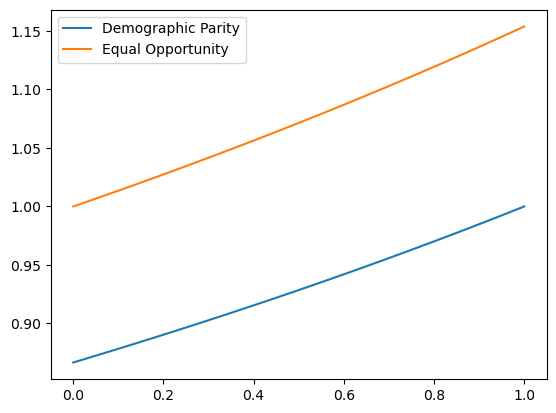

PRP max and min: 1.8461538461538463 1.8461538461538463  are equal


In [36]:
x = np.linspace(0, 1, 100)

def dp_combination(x):
    red_res_dp = np.array([demographic_parity(xx * red_dp + (1 - xx) * red_eo) for xx in x])
    return demographic_parity(blue) / red_res_dp

def eo_combination(x):
    red_res_eo = np.array([equal_opportunity(xx * red_dp + (1 - xx) * red_eo) for xx in x])
    return equal_opportunity(blue) / red_res_eo

def prp_combination(x):
    red_res_prp = np.array([predictive_rate_parity(xx * red_dp + (1 - xx) * red_eo) for xx in x])
    return predictive_rate_parity(blue) / red_res_prp


import matplotlib.pyplot as plt
plt.plot(x, dp_combination(x), label='Demographic Parity')
plt.plot(x, eo_combination(x), label='Equal Opportunity')
plt.legend()
plt.show()

print("PRP max and min:", prp_combination(x).max(), prp_combination(x).min(), " are equal")


# Task 2

## Training a model

### Data Preparation

For the second task I've used the compas dataset

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

data = pd.read_csv('datasets/compas/raw/compas-scores-two-years.csv')

In [38]:
def load_compas_data(df):
    features_to_keep = ["sex","age","age_cat","race","juv_fel_count","juv_misd_count","juv_other_count","priors_count","c_charge_degree","two_year_recid"] #"c_charge_desc",
    categorical_features = ["age_cat", "c_charge_degree", "sex", "race"]

    df = df[df["days_b_screening_arrest"] <= 30]
    df = df[df["days_b_screening_arrest"] >= -30]
    df = df[df["is_recid"] != -1]
    df = df[df["c_charge_degree"] != "O"]
    df = df[df["score_text"] != "N/A"]

    predictive = df[features_to_keep]
    # Favorable outcome == 1. Not recidivating within two years == 1
    y = (predictive["two_year_recid"] != 1).astype(int).to_frame()
    X = predictive.drop(columns=["two_year_recid"])
    X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    uint8_cols = X.select_dtypes(exclude="uint8").columns
    X[uint8_cols] = X[uint8_cols].astype("float32")

    return X, y, df

In [39]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
train_data, train_results, all_train = load_compas_data(train_set)
test_data, test_results, all_test = load_compas_data(test_set)

In [40]:
full_model = LogisticRegression(max_iter=10000)
full_model.fit(train_data, train_results.values.ravel())

LogisticRegression(max_iter=10000)

In [41]:
test_accuracy = accuracy_score(test_results, full_model.predict(test_data))
train_accuracy = accuracy_score(train_results, full_model.predict(train_data))

print("Train accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)

Train accuracy:  0.6740935790966174
Test accuracy:  0.6931174089068826


## Fairness coefficients

In [42]:
def demographic_parity(predictions, _, s):
    stat = predictions.mean()
    print(f"Demographic Parity for {s}: {stat}")
    return stat
    
def equal_opportunity(predictions, y, s):
    positive_outcome_subset = (y['two_year_recid'] == True)
    positive_outcome_predictions = predictions[positive_outcome_subset]
    stat = positive_outcome_predictions.mean()
    print(f"Equal Opportunity for {s}: {stat}")
    return stat

def predictive_rate_parity(predictions, y, s):
    positive_prediction_subset = (predictions == 1)
    true_positive_subset = (y['two_year_recid'][positive_prediction_subset] == True)
    stat = true_positive_subset.sum() / positive_prediction_subset.sum()
    print(f"Predictive Rate Parity for {s}: {stat}")
    return stat

def summarize_model(model, X, y, all_data):
    predictions = model.predict(X)
    male_ids =  (all_data['sex_Male'] == 1)
    female_ids =  (all_data['sex_Male'] != 1)

    caucasian_ids = (all_data['race_Caucasian'] == 1)
    non_caucasian = (all_data['race_Caucasian'] != 1)

    whole_population = predictions, y, "the whole population"
    males = predictions[male_ids], y[male_ids], "males"
    females = predictions[female_ids], y[female_ids], "females"
    caucasians = predictions[caucasian_ids], y[caucasian_ids], "caucasians"
    non_caucasians = predictions[non_caucasian], y[non_caucasian], "non caucasians"

    groups = [whole_population, males, females, caucasians, non_caucasians]
    tests = [
        (demographic_parity, "DEMOGRAPHIC PARITY"),
        (equal_opportunity, "EQUAL OPPORTUNITY"),
        (predictive_rate_parity, "PREDICTIVE RATE PARITY")
    ]

    results = {}
    for test, test_name in tests:
        print(f"*** {test_name} ***")
        group_results = {}
        for X, y, s in groups:
            group_results[s] = test(X, y, s)
        print("\n")
        results[test_name] = group_results
    return results

In [43]:
print("Simple Logistic Regression Model Summary")
default_model_results = summarize_model(full_model, test_data, test_results, all_test)


Simple Logistic Regression Model Summary
*** DEMOGRAPHIC PARITY ***
Demographic Parity for the whole population: 0.6089068825910932
Demographic Parity for males: 0.5538160469667319
Demographic Parity for females: 0.8732394366197183
Demographic Parity for caucasians: 0.7413394919168591
Demographic Parity for non caucasians: 0.5374064837905237


*** EQUAL OPPORTUNITY ***
Equal Opportunity for the whole population: 0.7675753228120517
Equal Opportunity for males: 0.7207207207207207
Equal Opportunity for females: 0.9507042253521126
Equal Opportunity for caucasians: 0.8411552346570397
Equal Opportunity for non caucasians: 0.719047619047619


*** PREDICTIVE RATE PARITY ***
Predictive Rate Parity for the whole population: 0.711436170212766
Predictive Rate Parity for males: 0.7067137809187279
Predictive Rate Parity for females: 0.7258064516129032
Predictive Rate Parity for caucasians: 0.7258566978193146
Predictive Rate Parity for non caucasians: 0.7006960556844548




## Another Model -- Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=8, min_samples_split=10)
random_forest_model.fit(train_data, train_results.values.ravel())

test_accuracy_rf = accuracy_score(test_results, random_forest_model.predict(test_data))
train_accuracy_rf = accuracy_score(train_results, random_forest_model.predict(train_data))

print("Random Forest Model")
print("Train accuracy: ", train_accuracy_rf)
print("Test accuracy: ", test_accuracy_rf)

Random Forest Model
Train accuracy:  0.7054891634595909
Test accuracy:  0.6890688259109312


In [45]:
random_forest_results = summarize_model(random_forest_model, test_data, test_results, all_test)

*** DEMOGRAPHIC PARITY ***
Demographic Parity for the whole population: 0.5708502024291497
Demographic Parity for males: 0.5303326810176126
Demographic Parity for females: 0.7652582159624414
Demographic Parity for caucasians: 0.6905311778290993
Demographic Parity for non caucasians: 0.5062344139650873


*** EQUAL OPPORTUNITY ***
Equal Opportunity for the whole population: 0.7302725968436155
Equal Opportunity for males: 0.6972972972972973
Equal Opportunity for females: 0.8591549295774648
Equal Opportunity for caucasians: 0.7906137184115524
Equal Opportunity for non caucasians: 0.6904761904761905


*** PREDICTIVE RATE PARITY ***
Predictive Rate Parity for the whole population: 0.7219858156028369
Predictive Rate Parity for males: 0.7140221402214022
Predictive Rate Parity for females: 0.7484662576687117
Predictive Rate Parity for caucasians: 0.7324414715719063
Predictive Rate Parity for non caucasians: 0.7142857142857143




## Models with agumented data

For data agumentation I've trained:
* A logistic regression model with balanced class data
* A logistic regression model with excluded sensitive features
* A random forest model with excluded sensitive features

In [46]:
balanced_model = LogisticRegression(max_iter=10000, class_weight='balanced')
balanced_model.fit(train_data, train_results.values.ravel())

test_accuracy_balanced = accuracy_score(test_results, balanced_model.predict(test_data))
train_accuracy_balanced = accuracy_score(train_results, balanced_model.predict(train_data))

print("Balanced Logistic Regression Model")
print("Train accuracy: ", train_accuracy_balanced)
print("Test accuracy: ", test_accuracy_balanced)

balanced_model_results = summarize_model(balanced_model, test_data, test_results, all_test)

Balanced Logistic Regression Model
Train accuracy:  0.6704476402673688
Test accuracy:  0.6761133603238867
*** DEMOGRAPHIC PARITY ***
Demographic Parity for the whole population: 0.5174089068825911
Demographic Parity for males: 0.4637964774951076
Demographic Parity for females: 0.7746478873239436
Demographic Parity for caucasians: 0.6374133949191686
Demographic Parity for non caucasians: 0.45261845386533667


*** EQUAL OPPORTUNITY ***
Equal Opportunity for the whole population: 0.6714490674318508
Equal Opportunity for males: 0.6234234234234234
Equal Opportunity for females: 0.8591549295774648
Equal Opportunity for caucasians: 0.740072202166065
Equal Opportunity for non caucasians: 0.6261904761904762


*** PREDICTIVE RATE PARITY ***
Predictive Rate Parity for the whole population: 0.7323943661971831
Predictive Rate Parity for males: 0.729957805907173
Predictive Rate Parity for females: 0.7393939393939394
Predictive Rate Parity for caucasians: 0.7427536231884058
Predictive Rate Parity for

In [47]:
model_excluding_race_sex = LogisticRegression(max_iter=10000)

to_exclude = ['sex_Male', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']
train_ex_race_sex = train_data.drop(columns=to_exclude)
test_ex_race_sex = test_data.drop(columns=to_exclude)

model_excluding_race_sex.fit(train_ex_race_sex, train_results.values.ravel())

LogisticRegression(max_iter=10000)

In [48]:
test_results_ex = model_excluding_race_sex.predict(test_ex_race_sex)
test_accuracy_excluding_race_sex = accuracy_score(test_results_ex, test_results)
print(test_accuracy_excluding_race_sex)

0.6923076923076923


In [49]:
print("Logistic Regression Model Summary (Excluding Racial and Sex Attributes)")
model_ex_race_sex_result = summarize_model(model_excluding_race_sex, test_ex_race_sex, test_results, all_test)

Logistic Regression Model Summary (Excluding Racial and Sex Attributes)
*** DEMOGRAPHIC PARITY ***
Demographic Parity for the whole population: 0.5983805668016194
Demographic Parity for males: 0.576320939334638
Demographic Parity for females: 0.704225352112676
Demographic Parity for caucasians: 0.7321016166281755
Demographic Parity for non caucasians: 0.5261845386533666


*** EQUAL OPPORTUNITY ***
Equal Opportunity for the whole population: 0.757532281205165
Equal Opportunity for males: 0.7423423423423423
Equal Opportunity for females: 0.8169014084507042
Equal Opportunity for caucasians: 0.8339350180505415
Equal Opportunity for non caucasians: 0.7071428571428572


*** PREDICTIVE RATE PARITY ***
Predictive Rate Parity for the whole population: 0.7144790257104194
Predictive Rate Parity for males: 0.6994906621392191
Predictive Rate Parity for females: 0.7733333333333333
Predictive Rate Parity for caucasians: 0.7287066246056783
Predictive Rate Parity for non caucasians: 0.7037914691943128


In [50]:
random_forest_model_agumented = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=8, min_samples_split=10)
random_forest_model_agumented.fit(train_ex_race_sex, train_results.values.ravel())

test_accuracy_rf_augmented = accuracy_score(test_results, random_forest_model_agumented.predict(test_ex_race_sex))
train_accuracy_rf_augmented = accuracy_score(train_results, random_forest_model_agumented.predict(train_ex_race_sex))

print("Random Forest Model Augmented")
print("Train accuracy: ", train_accuracy_rf_augmented)
print("Test accuracy: ", test_accuracy_rf_augmented)

random_forest_results_augmented = summarize_model(random_forest_model_agumented, test_ex_race_sex, test_results, all_test)


Random Forest Model Augmented
Train accuracy:  0.7010330160016204
Test accuracy:  0.6866396761133603
*** DEMOGRAPHIC PARITY ***
Demographic Parity for the whole population: 0.5603238866396761
Demographic Parity for males: 0.5332681017612525
Demographic Parity for females: 0.6901408450704225
Demographic Parity for caucasians: 0.6697459584295612
Demographic Parity for non caucasians: 0.5012468827930174


*** EQUAL OPPORTUNITY ***
Equal Opportunity for the whole population: 0.7187948350071736
Equal Opportunity for males: 0.6954954954954955
Equal Opportunity for females: 0.8098591549295775
Equal Opportunity for caucasians: 0.776173285198556
Equal Opportunity for non caucasians: 0.680952380952381


*** PREDICTIVE RATE PARITY ***
Predictive Rate Parity for the whole population: 0.7239884393063584
Predictive Rate Parity for males: 0.708256880733945
Predictive Rate Parity for females: 0.782312925170068
Predictive Rate Parity for caucasians: 0.7413793103448276
Predictive Rate Parity for non cau

## Summary

Different model types trained on different subsets yield similiar accuracy on the test set -- this means there is some room for fairness improvement without sacrificing accuracy.

In [51]:
print("Accuracies of models")
print("Simple Logistic Regression Model: ", test_accuracy)
print("Random Forest Model: ", test_accuracy_rf)
print("Logistic Regression Model (excluding race/sex): ", test_accuracy_excluding_race_sex)
print("Random Forest Model (excluding race/sex): ", test_accuracy_rf_augmented)
print("Balanced Logistic Regression Model: ", test_accuracy_balanced)

Accuracies of models
Simple Logistic Regression Model:  0.6931174089068826
Random Forest Model:  0.6890688259109312
Logistic Regression Model (excluding race/sex):  0.6923076923076923
Random Forest Model (excluding race/sex):  0.6866396761133603
Balanced Logistic Regression Model:  0.6761133603238867


In [52]:
print("Female to Male ratios:")
for test in default_model_results:
    print(f"*** {test} ***")
    print("Simple Logistic Model: ", default_model_results[test]['females'] / default_model_results[test]['males'])
    print("Random Forest Model: ", random_forest_results[test]['females'] / random_forest_results[test]['males'])
    print("Logistic Regression Model (excluding race/sex): ", model_ex_race_sex_result[test]['females'] / model_ex_race_sex_result[test]['males'])
    print("Random Forest Model (excluding race/sex): ", random_forest_results_augmented[test]['females'] / random_forest_results_augmented[test]['males'])
    print("Balanced Logistic Model: ", balanced_model_results[test]['females'] / balanced_model_results[test]['males'])
    print("\n")

Female to Male ratios:
*** DEMOGRAPHIC PARITY ***
Simple Logistic Model:  1.5767680286666996
Random Forest Model:  1.4429776692133118
Logistic Regression Model (excluding race/sex):  1.2219326143618927
Random Forest Model (excluding race/sex):  1.2941723736916912
Balanced Logistic Model:  1.6702323646520474


*** EQUAL OPPORTUNITY ***
Simple Logistic Model:  1.3191021126760563
Random Forest Model:  1.2321214106343488
Logistic Regression Model (excluding race/sex):  1.1004375769178176
Random Forest Model (excluding race/sex):  1.1644347953002991
Balanced Logistic Model:  1.3781242367499797


*** PREDICTIVE RATE PARITY ***
Simple Logistic Model:  1.0270161290322581
Random Forest Model:  1.0482395650037255
Logistic Regression Model (excluding race/sex):  1.105566343042071
Random Forest Model (excluding race/sex):  1.104560995382609
Balanced Logistic Model:  1.0129269574356279




In [53]:
print("Caucasian to non caucasians ratio:")
for test in default_model_results:
    print(f"*** {test} ***")
    print("Default Logistic Model: ", default_model_results[test]['caucasians'] / default_model_results[test]['non caucasians'])
    print("Random Forest Model: ", random_forest_results[test]['caucasians'] / random_forest_results[test]['non caucasians'])
    print("Logistic Model (excluding sex/race): ", model_ex_race_sex_result[test]['caucasians'] / model_ex_race_sex_result[test]['non caucasians'])
    print("Random Forest Model (excluding race/sex): ", random_forest_results_augmented[test]['caucasians'] / random_forest_results_augmented[test]['non caucasians'])
    print("Balanced Logistic Model: ", balanced_model_results[test]['caucasians'] / balanced_model_results[test]['non caucasians'])
    print("\n")

Caucasian to non caucasians ratio:
*** DEMOGRAPHIC PARITY ***
Default Logistic Model:  1.379476270341812
Random Forest Model:  1.364054198568812
Logistic Model (excluding sex/race):  1.3913400391843527
Random Forest Model (excluding race/sex):  1.3361598474141994
Balanced Logistic Model:  1.4082797320252705


*** EQUAL OPPORTUNITY ***
Default Logistic Model:  1.1698185382647572
Random Forest Model:  1.1450267645960415
Logistic Model (excluding sex/race):  1.1793020457280383
Random Forest Model (excluding race/sex):  1.1398348943475298
Balanced Logistic Model:  1.181864353269001


*** PREDICTIVE RATE PARITY ***
Default Logistic Model:  1.0359080687421343
Random Forest Model:  1.0254180602006688
Logistic Model (excluding sex/race):  1.0354013319313005
Random Forest Model (excluding race/sex):  1.0420786110441285
Balanced Logistic Model:  1.0251694494957844




Key observations:
* Predictive Rate Parity was the most balanced coefficient across all the models. This means that all the models trained in this experiment, by default tend to assume the judges perspective (which is coherent with the loss function).

* For ratio of fairness coefficients between females and males, the biggest improvements were achieved by simply excluding the features from the training data. This technique made all the fairness coefficient fall into "four-fifth" rules acceptable range. In both the random model and the logistic regression model, this improved the fairness.

* Without the exclusion of the data / weighting, the fairness coefficients were in every case more balanced with the random forest model than the logistic regression. Adding additional weight to the underrepresented examples might further lower fairness, by guiding the model to focus more on the protected attributes.

* While the Equal Opportunity coefficient was close-to balanced in respect to the 'race' attribute, it was not the case for sex. For the latter, this attribute must have been excluded from the training data to achieve a balanced coefficient.